### Problem Overview

### Import the Libaries

Music streaming platforms like Spotify generate vast amounts of data related to song characteristics, user preferences, and listening habits. Understanding patterns in this data can help in tasks such as music recommendation, playlist generation, and genre discovery. In this project we are to focus on using clustering techniques to group songs based on their audio features, uncovering hidden structures in the dataset. By analyzing these clusters, one can gain insights into different music styles and potentially enhance recommendation systems.

In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
import plotly.express as px
import plotly.graph_objects as go

# Preprocessing and feature scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Clustering algorithms
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Statistical analysis
from scipy import stats
from scipy.cluster.hierarchy import fcluster

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

### LOAD DATA

In [4]:
data = pd.read_csv('/content/ML_spotify_data.csv')
data.head()

FileNotFoundError: [Errno 2] No such file or directory: '/content/ML_spotify_data.csv'

feature descriptions:

- Acousticness: A measure of acoustic sound in a track
- Danceability: How suitable a track is for dancing
- Energy: Intensity and activity level of a song
- Instrumentalness: The presence of vocals in a track
- Liveness: Detects the presence of a live audience
- Loudness: The overall loudness of a track
- Speechiness: The presence of spoken words in a track
- Tempo: The beats per minute (BPM) of a song
- Valence: The musical positiveness of a track

### EDA

In [ ]:
def initial_data_exploration(df):
    """Perform initial data exploration"""
    print("=== DATASET OVERVIEW ===")
    print(f"Dataset shape: {data.shape}")

    print("\n=== COLUMN INFORMATION ===")
    print(data.info())

    print("\n=== BASIC STATISTICS ===")
    display(data.describe())

    print("\n=== MISSING VALUES ===")
    missing_values = data.isnull().sum()
    print(missing_values[missing_values > 0])

    print("\n=== DUPLICATE ROWS ===")
    print(f"Number of duplicate rows: {data.duplicated().sum()}")

    print("\n=== UNIQUE VALUES ===")
    for col in data.columns:
        print(f"{col}: {data[col].nunique()}")

  # Run initial exploration
initial_data_exploration(data)

=== DATASET OVERVIEW ===
Dataset shape: (10000, 12)

=== COLUMN INFORMATION ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   name          10000 non-null  object 
 1   artists       10000 non-null  object 
 2   popularity    10000 non-null  int64  
 3   danceability  10000 non-null  float64
 4   valence       10000 non-null  float64
 5   energy        10000 non-null  float64
 6   explicit      10000 non-null  int64  
 7   key           10000 non-null  int64  
 8   liveness      10000 non-null  float64
 9   loudness      10000 non-null  float64
 10  speechiness   10000 non-null  float64
 11  tempo         10000 non-null  float64
dtypes: float64(7), int64(3), object(2)
memory usage: 937.6+ KB
None

=== BASIC STATISTICS ===


popularity  danceability       valence        energy      explicit  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean      37.556800      0.549507      0.523148      0.592609      0.103200   
std       12.559743      0.178097      0.261456      0.251808      0.304235   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%       27.000000      0.430000      0.313000      0.414000      0.000000   
50%       36.000000      0.557000      0.524500      0.616000      0.000000   
75%       46.000000      0.681000      0.742000      0.801000      0.000000   
max       86.000000      0.986000      0.996000      1.000000      1.000000   

               key      liveness      loudness   speechiness         tempo  
count  10000.00000  10000.000000  10000.000000  10000.000000  10000.000000  
mean       5.20560      0.209787     -9.822324      0.081426    120.179723  
std        3.56205      0.193693      5.321064      0.100472     30.260748  
min        0.00000      0.000000    -60.000000      0.000000      0.000000  
25%        2.00000      0.093900    -12.347250      0.034200     96.191250  
50%        5.00000      0.129000     -8.762000      0.045100    118.330500  
75%        9.00000      0.261250     -6.070750      0.077400    139.609500  
max       11.00000      1.000000      1.073000      0.957000    224.437000


=== MISSING VALUES ===
Series([], dtype: int64)

=== DUPLICATE ROWS ===
Number of duplicate rows: 1

=== UNIQUE VALUES ===
name: 9711
artists: 5723
popularity: 68
danceability: 903
valence: 1225
energy: 1216
explicit: 2
key: 12
liveness: 1453
loudness: 7405
speechiness: 1171
tempo: 9370


### Insights on Analysis
1. We have 12 columns and 10000 rows
2. No missing values
3. We have 1 duplicated row(Which we will remove)

### Data Preprocessing

In [ ]:
# Remove Duplicates
data = data.drop_duplicates()

data.shape

#data.describe()

(9999, 12)

### Feature Transformation

In [ ]:
# Select relevant audio features for clustering
features = ['danceability', 'energy', 'loudness', 'speechiness',
            'liveness', 'valence', 'tempo']
data_selected = data[features].copy()

In [ ]:
# feature scaling to [0,1] range
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data_selected)

In [ ]:
#Transform the scaled data
data_scaled = pd.DataFrame(data_scaled, columns=features)

##This makes the scaled data easier to work with as it now has meaningful column labels.###

### Clustering
1. KMeans is an unsupervised learning algorithm widely used for partitioning data into k distinct groups based on feature similarity. The algorithm iteratively assigns each observation to the nearest cluster centroid and updates centroids as the mean of the assigned points until convergence.
  
### Key hyperparameters:

* n_clusters=k: Specifies the number of clusters (k) to be formed.

* random_state=42: Controls the randomness of centroid initialization, ensuring reproducibility of results.


#### Model evaluation – Within-Cluster Sum of Squares (WCSS)

* WCSS measures the compactness of clusters, with lower values indicating tighter groupings.
* To determine an optimal number of clusters, practitioners commonly use the Elbow Method, plotting WCSS against different values of k and identifying the “elbow point” where additional clusters yield diminishing returns in variance reduction.

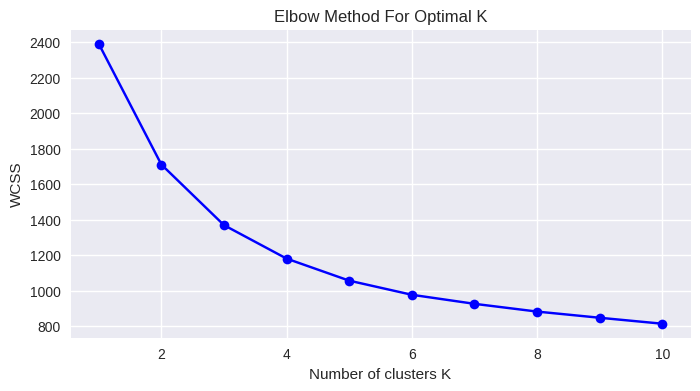

In [ ]:
# Find the optimal K
wcss = []
K_range = range(1, 11)
for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(data_scaled)
    wcss.append(km.inertia_)

plt.figure(figsize=(8,4))
plt.plot(K_range, wcss, 'bo-')
plt.xlabel('Number of clusters K')
plt.ylabel('WCSS')
plt.title('Elbow Method For Optimal K')
plt.show()

### Insights
- Our K will be 4 clusters

In [ ]:
# fit KMeans
k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(data_scaled)

data['cluster'] = clusters # associate each song with its assigned cluster.

Kmeans Visualization

Text(0.5, 1.0, 'KMeans Clustering')

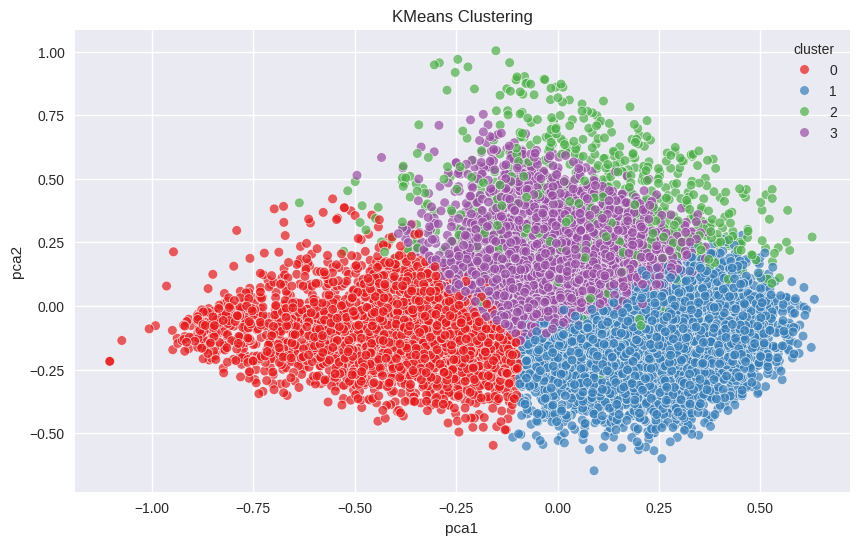

In [ ]:
# Plot the Kmeans clustering using 2D PCA
pca = PCA(n_components=3, random_state=42)
data_pca = pca.fit_transform(data_scaled)

data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='cluster', data=data, palette='Set1', alpha=0.7)
plt.title('KMeans Clustering')

In [ ]:
# Plot the Kmeans clustering using 3D PCA
pca = PCA(n_components=3, random_state=4)
data_pca = pca.fit_transform(data_scaled)

data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]
data['pca3'] = data_pca[:, 2]

fig = px.scatter_3d(data, x='pca1', y='pca2', z='pca3', color='cluster',
                    title='KMeans Clustering')
fig.show()


In [ ]:
# evaluate the kmeans using silhouette score
from sklearn.metrics import silhouette_score

silhouette_avg = silhouette_score(data_scaled, clusters)
print("Silhouette Score:", silhouette_avg)

Silhouette Score: 0.25841412213108167


2. Hierarchical Clustering
* Initiate the model
* Compute the linkage matrix
* Plot the dendogram - To show how clusters are broken down at each step
* Choose the number of clusters you would want to work with

In [ ]:
#Initiate the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=3)

# fit model and predict clusters
yhat_AC = AC.fit_predict(data_scaled)

#Add the Clusters feature to the orignal dataframe.
data = pd.DataFrame(data_scaled, columns=['pca1', 'pca2'])
data["Clusters"]= yhat_AC

In [ ]:
# Compute linkage matrix
# 'ward' minimizes variance within the clusters & Good for Euclidean Distance
linked = linkage(data_scaled, method='ward')

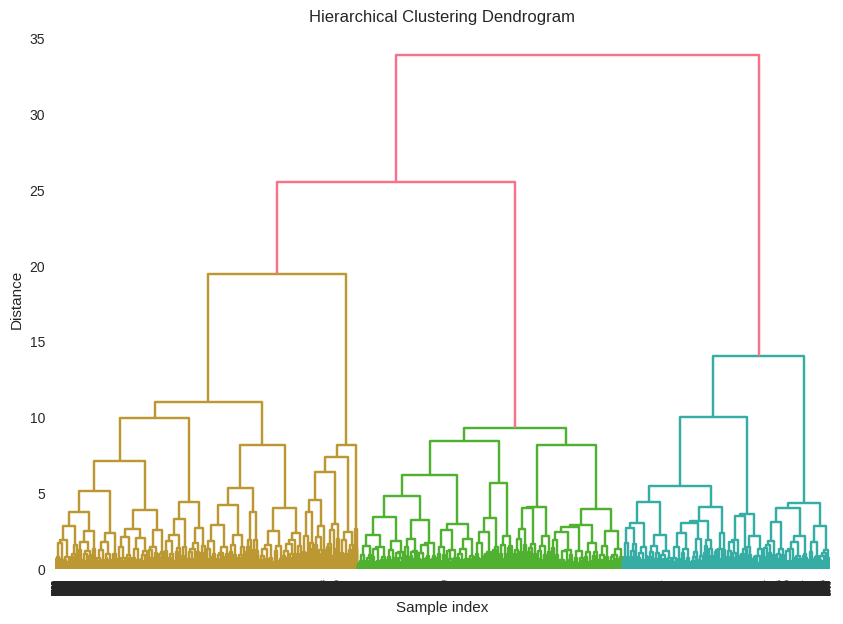

In [ ]:
# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            distance_sort='descending',
            show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [ ]:
#choose the number of clusters based on the dendrogram or domain knowledge.

#criterion='maxclust' allows you to specify the exact number of clusters.
#criterion='distance' lets you cut the dendrogram at a specific distance.
clusters = fcluster(linked, 10, criterion='distance')

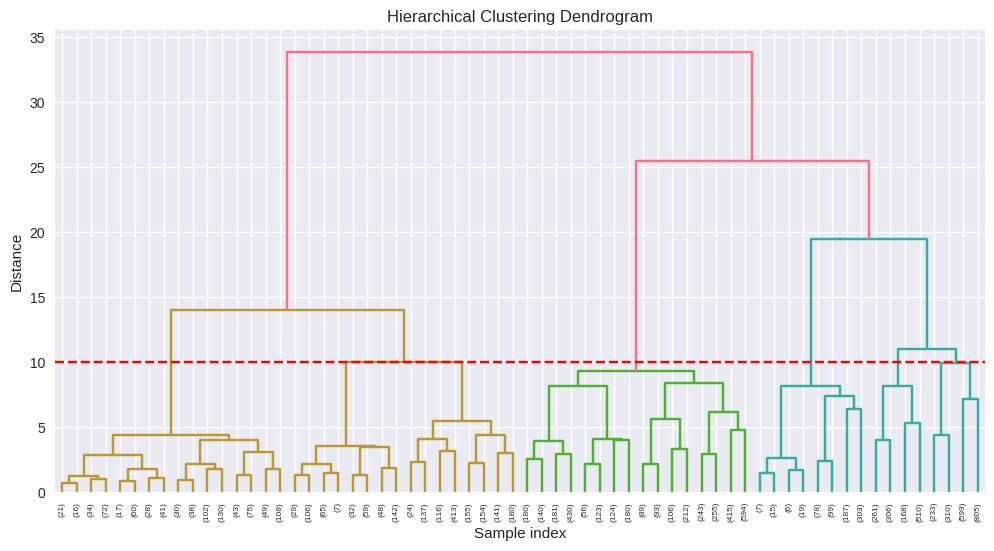

In [ ]:
plt.figure(figsize=(12, 6))
dendrogram(linked, truncate_mode='level', p=5)  # show last 5 merges

# Draw horizontal line to indicate the cut for n_clusters
plt.axhline(y=10, color='r', linestyle='--')

plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

Text(0.5, 1.0, 'Hierarchical Clustering')

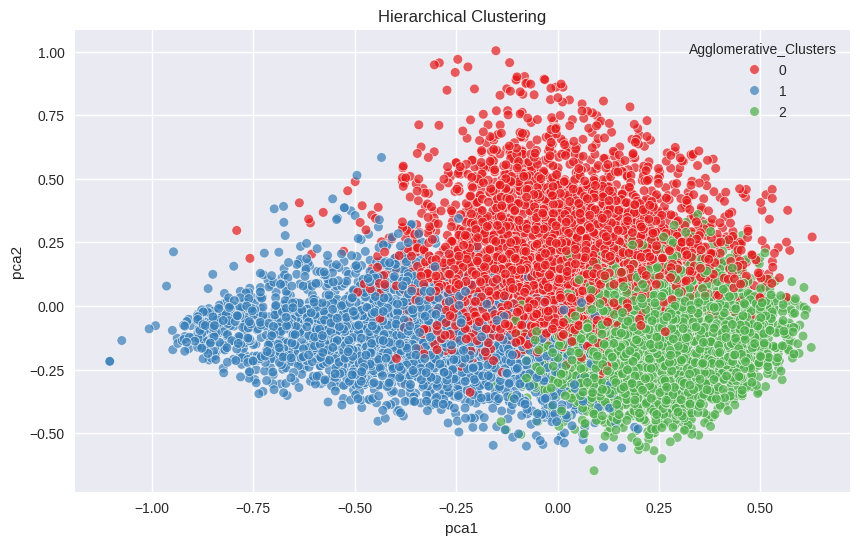

In [ ]:
#visualize the hierarchical clustering in 2D using PCA
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data_scaled)

data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]

# Add the Agglomerative Clustering assignments to the data DataFrame
data['Agglomerative_Clusters'] = yhat_AC
plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='Agglomerative_Clusters', data=data, palette='Set1', alpha=0.7)
plt.title('Hierarchical Clustering')

3. DBSCAN

In [ ]:
# FiT  DBSCAN
from sklearn.metrics.pairwise import euclidean_distances
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='euclidean')
dbscan_clusters = dbscan.fit_predict(data_scaled)

Text(0.5, 1.0, 'DBSCAN Clustering')

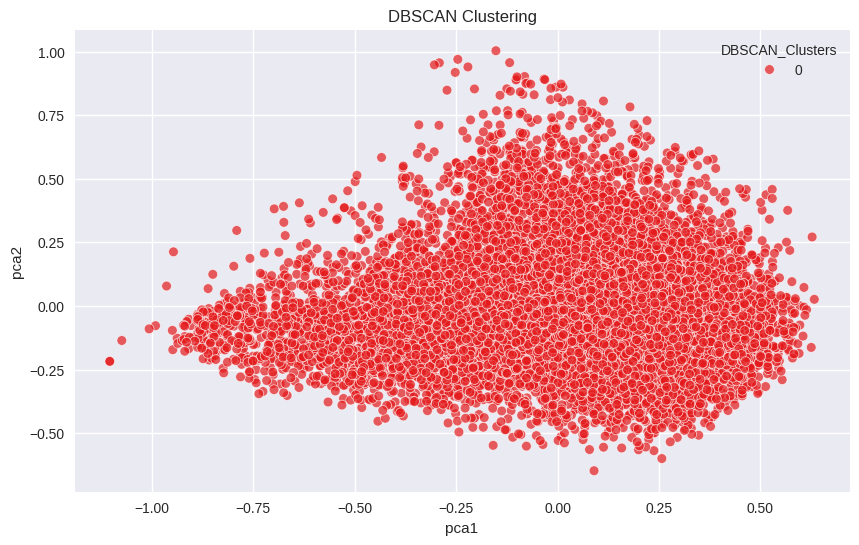

In [ ]:
# Plot the DBSCAN clussters using 2D PCA
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data_scaled)

data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]

# Add the DBSCAN cluster assignments to the data DataFrame
data['DBSCAN_Clusters'] = dbscan_clusters

plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='pca1', y='pca2', hue='DBSCAN_Clusters', data=data, palette='Set1', alpha=0.7)
plt.title('DBSCAN Clustering')

# Add color

In [ ]:
# Perform PCA with 3 components for 3D visualization
pca = PCA(n_components=3, random_state=42)
data_pca = pca.fit_transform(data_scaled)

# Add the PCA components to the data DataFrame
data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]
data['pca3'] = data_pca[:, 2]

#Create a 3D scatter plot for DBSCAN
fig = px.scatter_3d(data, x='pca1', y='pca2', z='pca3', color='DBSCAN_Clusters',
                    title='DBSCAN Clustering')
fig.show()

4. GMM

In [ ]:
# Initialize Gaussian Mixture Method (GMM)
n_components = np.arange(1,10)
gmm = [GaussianMixture(n, random_state=42).fit(data_scaled) for n in n_components]
bics = [m.bic(data_scaled) for m in gmm]
best_n = np.argmin(bics) + 1

print("Optimal number of clusters:", best_n)


Optimal number of clusters: 9


In [ ]:
#Fit GMM with 3 components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_clusters = gmm.fit_predict(data_scaled)

print("GMM Cluster Centers:\n", gmm.means_)
print('GMM clusters:', gmm_clusters[:10])

GMM Cluster Centers:
 [[0.52649682 0.45619254 0.78427404 0.03829118 0.10501782 0.46677818
  0.51336548]
 [0.56387533 0.66612979 0.84307118 0.05853156 0.20688748 0.5764902
  0.54986541]
 [0.59570543 0.69152463 0.84651784 0.20186478 0.38047174 0.53603872
  0.54754115]]
GMM clusters: [0 0 1 2 1 0 0 1 1 2]


### Visualization

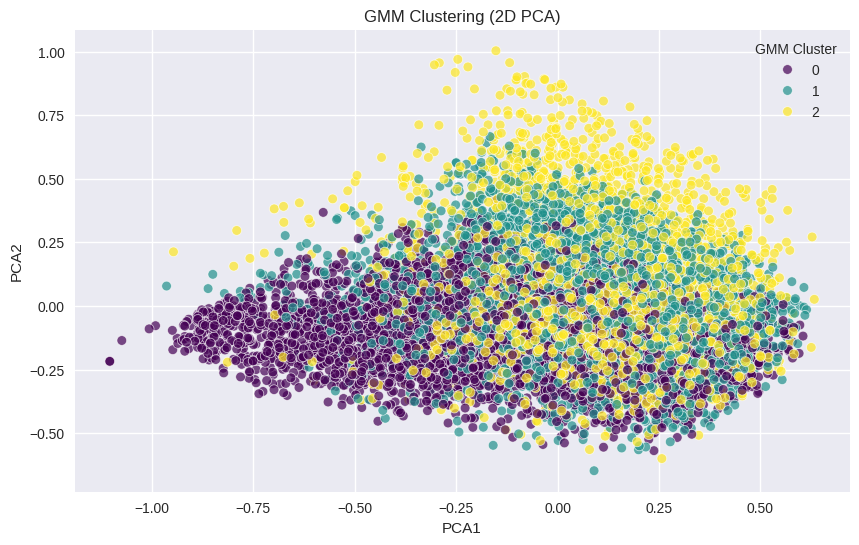

In [ ]:
# PCA for 2D Visualization for GMM
pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data_scaled)

data['pca1'] = data_pca[:, 0]
data['pca2'] = data_pca[:, 1]

# Add the GMM cluster assignments to the data DataFrame
data['GMM_Clusters'] = gmm_clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(x='pca1', y='pca2', hue='GMM_Clusters', data=data, palette='viridis', alpha=0.7)
plt.title('GMM Clustering (2D PCA)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='GMM Cluster')
plt.show()

In [ ]:
#Create a 3D visualization for GMM
fig = px.scatter_3d(data, x='pca1', y='pca2', z='pca3', color='GMM_Clusters',
                    title='GMM Clustering')
fig.show()

In [ ]:
# Create a DataFrame with original features and KMeans cluster assignments
clustered_data = data_selected.copy()
clustered_data['cluster'] = clusters

# Average audio features per cluster
cluster_summary = clustered_data.groupby('cluster')[features].mean()
print("\nAverage audio features per cluster:\n", cluster_summary)


Average audio features per cluster:
          danceability    energy   loudness  speechiness  liveness   valence  \
cluster                                                                       
1            0.620731  0.346114 -12.837793     0.050507  0.153515  0.537843   
2            0.252549  0.093720 -23.101643     0.042062  0.127013  0.105704   
3            0.438237  0.315628 -13.009314     0.041083  0.150006  0.262209   
4            0.670633  0.670122  -8.482372     0.095553  0.151170  0.780899   
5            0.468480  0.685947  -9.684934     0.135665  0.757311  0.500751   
6            0.505875  0.838782  -6.129418     0.107721  0.272290  0.541728   
7            0.512531  0.686896  -7.761843     0.070864  0.157926  0.341509   

              tempo  
cluster              
1        111.484169  
2         98.067564  
3        111.488591  
4        122.070234  
5        123.017272  
6        130.507170  
7        124.505069  
